# Waymo
- global poses, not synchronized to the "origin"
- Flows are not consistent if 'velocity' is used?
- use preprocessing from other dataset based on bounding boxes

# Argoverse, Nuscenes
- beware of sampling rate, poses, and max distances/heights


  0%|          | 0/37 [00:00<?, ?it/s]


dict_keys(['pc1', 'pc2', 'gt_flow', 'full_pc2', 'padded_mask_N', 'padded_mask_M', 'relative_pose', 'box1', 'id_mask1', 'mos1', 'epe', 'loss', 'pred_flow'])


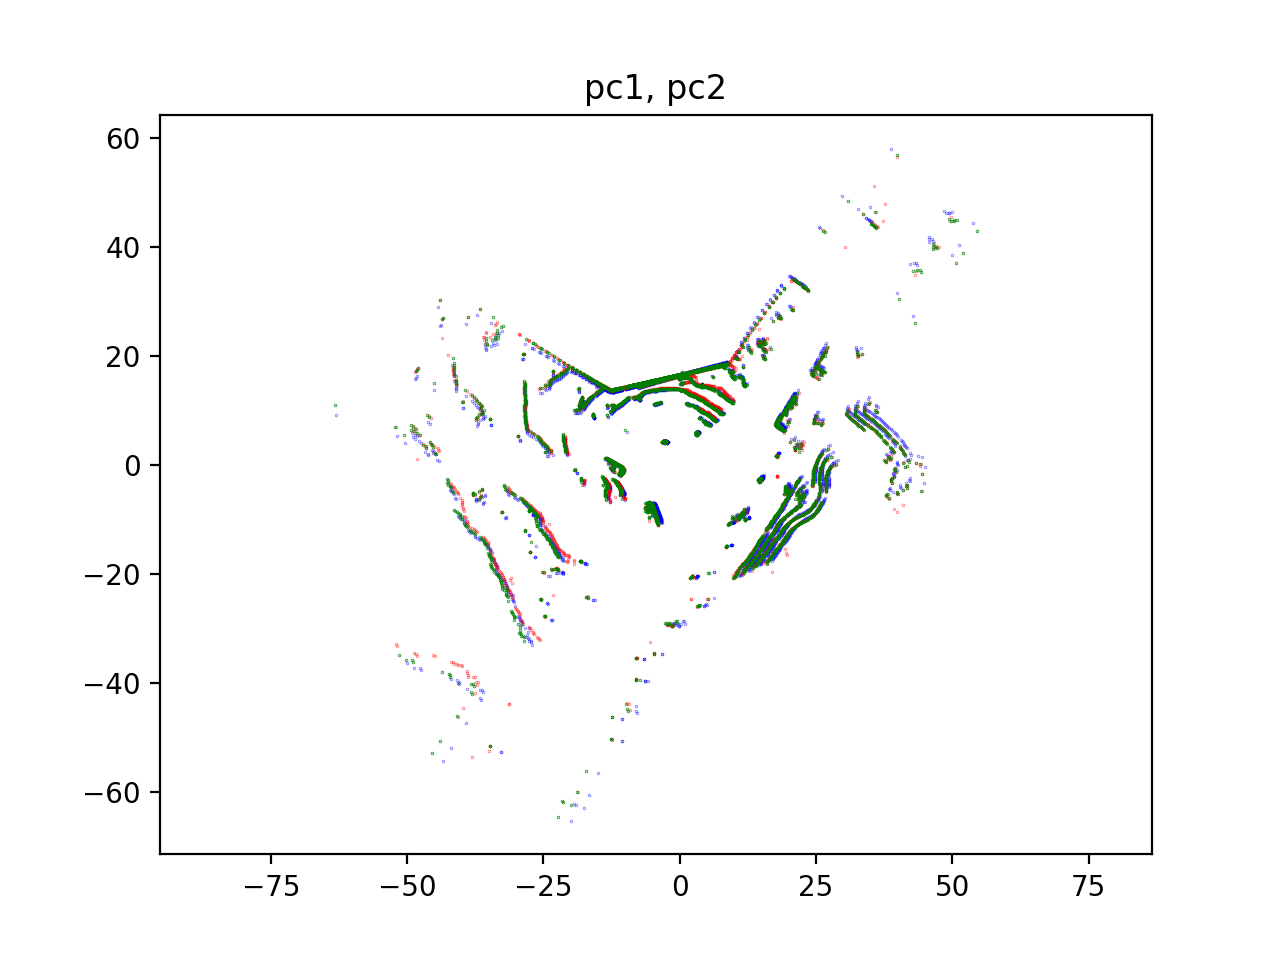

In [34]:
import os
import sys
sys.path.append('..')
import numpy as np
import torch
import glob
import numpy as np
from data.PATHS import DATA_PATH
from data.dataloader import SFDataset4D
import importlib
from vis.deprecated_vis import visualize_points3D, visualize_multiple_pcls, visualize_flow3d, imshow


if __name__ == '__main__':
    dataset_type = 'nuscenes'
    data_split = 'train'
    # sequence = '*'
    sequence = 'scene-0001'
    # sequence = 'segment-14098575914252965554_511_000_531_000_with_camera_labels.tfrecord'
    frame = '*' # name of the frame, not number
    
#     ds = SFDataset4D(root_dir=os.path.join(DATA_PATH, 'sceneflow'), dataset_type='waymo', n_frames=2)
    ds = SFDataset4D(dataset_type=dataset_type, data_split=data_split, sequence=sequence, frame=frame, n_frames=2)
    
    from tqdm import tqdm
    
    for data_dict in tqdm(ds):
    
        break
    
    # visualize_flow3d(data_dict['pc1'][0], data_dict['pc2'][0], data_dict['gt_flow'][0][:,:3])
    # visualize_points3D(data_dict['pc1'][0], data_dict['mos1'][0])
    rel_pos = data_dict['relative_pose'][0]
    pc1 = data_dict['pc1'][0]
    gt_flow = data_dict['gt_flow'][0][:,:3]
    
    def_pc1 = (np.insert(pc1, 3, 1, axis=1) @ rel_pos.T)
    rigid_flow = def_pc1[:, :3] - pc1
    flow_diff = np.linalg.norm(rigid_flow - gt_flow, axis=1)
    # todo add pose1 pose2
    # todo Nuscenes is not synchronized everywhere, some frames are dropped
    # visualize_points3D(pc1, flow_diff)
    # visualize_points3D(pc1, data_dict['mos1'][0])
    # visualize_flow3d(pc1, data_dict['pc2'][0], data_dict['gt_flow'][0])
    
data = data_dict
data['epe'] = torch.arange(0,10, 0.1)
data['loss'] = torch.arange(0,10, 0.1)  # dont do more losses now
data['pred_flow'] = data['gt_flow']
print(data_dict.keys())

import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=200)
ax.scatter(data['pc1'][0][:,0], data['pc1'][0][:,1], c='b', s=0.05, alpha=0.6)
ax.scatter(data['pc2'][0][:,0], data['pc2'][0][:,1], c='r', s=0.05, alpha=0.6)
ax.scatter(data['pc1'][0][:,0] + data['pred_flow'][0][:,0], data['pc1'][0][:,1] + data['pred_flow'][0][:,1], c='g', s=0.05, alpha=1)
ax.set_title('pc1, pc2')
ax.axis('equal')
# ax[0].set_xlim(-50, 50)
imshow(fig)
plt.close()

In [1]:
# 2D plots
# %load_ext autoreload
# %autoreload 2
# todo losses
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.close()
# plt.scatter(pc1[:,0], pc1[:,1], pc1[:,2], marker=1, alpha=0.8)
fig, ax = plt.subplots(dpi=700)
plt.plot(pc1[:,0], pc1[:,1], 'b.', markersize=0.2, alpha=0.2)
plt.quiver(pc1[:, 0], pc1[:, 1], gt_flow[:, 0], gt_flow[:, 1], color='g', scale=1, units='xy')
noisy_flow = gt_flow + np.random.rand(gt_flow.shape[0],3) * 0.5
plt.quiver(pc1[:, 0], pc1[:, 1], noisy_flow[:,0], noisy_flow[:,1], color='r', scale=1, units='xy')
plt.axis('equal')
# plt.show()
plt.savefig('tmp.png')
imshow(fig=plt)


NameError: name 'pc1' is not defined

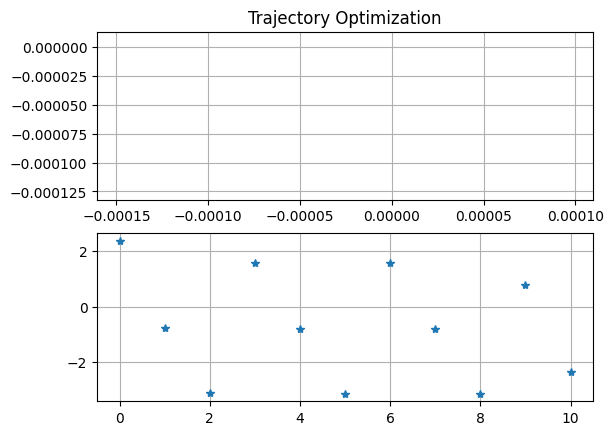

In [7]:
# motion Ruslan
import sys
sys.path.append('..')
import os
import torch
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output

from vis.deprecated_vis import visualize_points3D, visualize_multiple_pcls, visualize_flow3d, imshow
from loss import path
from data.path_utils import get_traj


# ds = SFDataset4D(root_dir=os.path.join(DATA_PATH, 'sceneflow'), dataset_type='waymo', n_frames=11)
ds = SFDataset4D(dataset_type=dataset_type, data_split=data_split, sequence=sequence, frame=frame, n_frames=11)

device = torch.device('cuda:0')
# visualize_points3D(trajectory[:,:3], trajectory[:,-1])
xyza = get_traj(data_sample=ds[0])
xyza_init = xyza.detach().clone()
xyza.requires_grad_(True).to(device)

fig, ax = plt.subplots(2)
cmap, norm = mcolors.from_levels_and_colors([0, 2, 5, 6], ['red', 'green', 'blue'])
# optimize trajectory to have smooth heading
optimizer = torch.optim.Adam([xyza], lr=0.1)

max_iter = 100
dt = 1.
for i in range(max_iter):
    optimizer.zero_grad()
    loss = path.path_smoothness(xyza)
    loss.backward()
    optimizer.step()
    print('iter {}, loss: {:.4f}'.format(i, loss.item()))
    
    d_xyza = torch.diff(xyza, dim=0) / dt
    heading = torch.atan2(d_xyza[:, 1], d_xyza[:, 0])
    
    print(heading)
    # plot
    
    ax[0].cla()
    ax[1].cla()
    ax[0].set_xlim(xyza_init[:,0].min(), xyza_init[:,0].max())
    ax[0].set_ylim(xyza_init[:,1].min(), xyza_init[:,1].max())
    ax[0].set_title('Trajectory Optimization')
    ax[0].grid(True)
    plt.grid(True)
    ax[0].scatter(xyza[:-1,0].detach().cpu(), xyza[:-1,1].detach().cpu(), c=heading.detach().cpu(), cmap=cmap, norm=norm)
    # fig.colorbar(heading.detach().cpu().numpy(), ax=ax[0])
    clear_output(wait=True)
    
    
    ax[1].plot(heading.detach().cpu(), '*')
    
    if i != max_iter-1:
        imshow(fig)
    
    